<div style="background: navy; color: white; padding: 20px">


# $\S 4.6$: Comparing anomaly detection methods on path space

In this notebook, we step through the examples shown in Section 4.6 of the paper "Non-parametric online market regime detection and regime clustering for multidimensional and path-dependent data structures".

<div style="background: navy; color: white; padding: 20px">

### Imports

In [23]:
import torch
import numpy as np

from src.testing import TestConfig
from src.testing.discriminators import GeneralMMDDetector, AutoEvaluator, TruncatedMMDDetector, TruncatedAutoEvaluator, AnomalyDetector
from src.testing.discriminators.config import ProcessorConfig
from src.testing.experiment_functions.mmd_test_functions import generate_deterministic_test_path, get_set_paths, alpha_score_function, get_beliefs_from_config
from src.testing.experiment_functions.plot_result_functions import plot_path_experiment_result, plot_path_test_threshold
from src.testing.clustering.HierarchicalClusterer import HierarchicalClusterer
from src.testing.clustering.config import ClusterConfig
from src.testing.output_functions import get_table_statistics
from src.generators.Model import Model
from src.generators.config import ModelConfig
from src.utils.auxiliary_classes.PathTransformer import PathTransformer, PathTransformerConfig
from src.utils.auxiliary_classes.RegimePartitioner import RegimePartitioner, RegimePartitionerConfig
from src.utils.Config import Config
from src.utils.helper_functions.test_helper_functions import get_memberships, get_alphas, get_sub_paths, get_grouped_paths
from src.utils.helper_functions.plot_helper_functions import plot_regime_change_path, plot_scores

In [24]:
device = "cuda" if torch.cuda.is_available() else "cpu"

<div style="background: navy; color: white; padding: 20px">

## 1. Configuration

See the <code>5-online-regime-detection.ipynb</code> notebook for line-by-line descriptions of configurations.

In [29]:
# Set configs
test_config             = TestConfig()
model_config            = ModelConfig()
path_transformer_config = PathTransformerConfig()
processor_config        = ProcessorConfig()
regime_config           = RegimePartitionerConfig()

dim = 5

model_config.override_args({
    "year_mesh": 7*252,
    "attach_volatility": False
})

dt = 1/model_config.year_mesh
belief_models = ["gbm"]
model_pair_names = ["gbm", "gbm"]

belief_params = [[[0., 0.2] for _ in range(dim)]]
model_pair_params = [[[0., 0.2] for _ in range(dim)], [[0., 0.3] for _ in range(dim)]]

test_config.override_args({
    "n_steps": 8,
    "n_paths": 16,
    "offset" : 0,
    "weight_factor": 1,
    "belief_models": belief_models,
    "model_pair_names": model_pair_names,
    "belief_params": belief_params,
    "model_pair_params": model_pair_params,
    "path_bank_size": 100000
})

path_transformer_config.set_transformations({
    "standardise_path_transform":    (True , 0, {"s_type": "initial"}),
    "time_normalisation_transform":  (True , 0, {}),
    "time_difference_transform":     (False, 0, {}),
    "difference_transform":          (False, 0, {}),
    "translation_transform":         (False, 0, {}),
    "scaling_transform":             (False, 0, {"sigmas": [(1/dt)**1e0 for _ in range(dim)]}),
    "cumulant_transform":            (False, 2, {}),
    "increment_transform":           (False, 2, {}),
    "lead_lag_transform":            (False, 3, {}),
    "invisibility_transform":        (False, 4, {}),
})
path_transformer_config.compute_pathwise_signature_transform = False
path_transformer_config.signature_order = 8

processor_config.override_args({
    "generalmmddetector_kwargs": Config(**{
        "n_tests": 512,
        "n_evaluations": 1,
        "metric_kwargs": Config(**{
            "kernel_type": "rbf",
            "metric_type": "mmd",
            "sigmas": [2.5e-3],
            "dyadic_orders": [2],
            "lambd": 5
        }),
        "evaluator_kwargs": Config(**{
            "pct_ignore": 0.1
        })
    }),
    "truncatedmmddetector_kwargs": Config(**{
        "n_tests": 512,
        "n_evaluations": 1,
        "metric_kwargs": Config(**{
            "signature_order": 2,
            "scale_signature": False,
            "sigma": None
        })
    }),
    "anomalydetector_kwargs": Config(**{
        "signature_depth": 2,
        "signature_type": "signature",
        "pct_path_bank": 0.01
    }),
    "alpha_value": 0.95,
    "device": device,
    "overwrite_prior": True
})

regime_config.override_args({
    "n_regime_changes": 5,
    "f_length_scale"  : 0.5,
    "type"            : "random_on_off_steps",
    "r_on_args"       : ["poisson", 2],
    "r_off_args"      : ["poisson", 1/30],
    "r_min_distance"  : 32,
    "r_min_gap"       : 32
})

<div style="background: navy; color: white; padding: 20px">

## 2. Instantiate beliefs

In [31]:
beliefs, belief_details, model_pairs = get_beliefs_from_config(test_config, model_config, overwrite=False)
path_transformer                     = PathTransformer(path_transformer_config)

100%|████████████████████████████████| 100000/100000 [00:09<00:00, 11012.03it/s]


<div style="background: navy; color: white; padding: 20px">

## 3. Generate regime-change path

In [32]:
# Generate path for testing
T = 4
S0 = [1. for _ in range(dim)]
n_steps = test_config.n_steps
n_paths = test_config.n_paths
offset = 0

regime_partitioner = RegimePartitioner(model_config.year_mesh, regime_config)
regime_partitioner.generate_regime_partitions(T=T, n_steps=n_steps)
test_path = regime_partitioner.generate_regime_change_path(model_pairs, S0)

<div style="background: navy; color: white; padding: 20px">

## 4. Instantiate detection objects

In [34]:
general_detector = GeneralMMDDetector(
    beliefs          = beliefs,
    path_details     = belief_details,
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

100%|████████████████████████████████| 100000/100000 [00:01<00:00, 67615.67it/s]


Metric initialized. MMD1, sigma=0.0025, kernel = rbf, dyadic_order = 2


512it [00:04, 113.07it/s]


In [35]:
truncated_detector = TruncatedMMDDetector(
    beliefs          = beliefs,
    path_details     = belief_details,
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

100%|████████████████████████████████| 100000/100000 [00:01<00:00, 72113.23it/s]
512it [00:00, 2437.63it/s]


In [37]:
anomaly_detector = AnomalyDetector(
    beliefs          = beliefs,
    path_details     = belief_details,
    path_transformer = path_transformer,
    processor_config = processor_config,
    test_config      = test_config
)

100%|████████████████████████████████| 100000/100000 [00:01<00:00, 65368.66it/s]


Calibrating variance norm...


100%|████████████████████████████████████████| 500/500 [00:02<00:00, 228.60it/s]


<div style="background: navy; color: white; padding: 20px">

## 5. Calculate scores over path

In [38]:
general_scores_array   = general_detector.evaluate_path(test_path, evaluation="total")
truncated_scores_array = truncated_detector.evaluate_path(test_path, evaluation="total")
anomaly_scores_array   = anomaly_detector.evaluate_path(test_path)

100%|████████████████████████████████████████| 882/882 [00:03<00:00, 227.43it/s]


<div style="background: navy; color: white; padding: 20px">

## 6. Display results

In [39]:
# Extract sub paths for score functions
sub_paths = get_sub_paths(test_path, n_steps, offset)
mmd_paths = get_grouped_paths(sub_paths, n_paths)
c_alpha   = general_detector.critical_value
c_alpha_t = truncated_detector.critical_value

# Get alpha scores for test thresholds
memberships    = get_memberships(mmd_paths)
mmd_alphas     = get_alphas(memberships, general_scores_array, c_alpha)
mmd_t_alphas   = get_alphas(memberships, truncated_scores_array, c_alpha_t)
anomaly_alphas = 1.0*(anomaly_scores_array[1, :] > anomaly_detector.critical_value)

_, regime_changes, _ = regime_partitioner.changes_to_times()
path_splits_time = [item for sublist in [[r[0], r[1] + 1/model_config.year_mesh] for r in regime_changes] for item in sublist]
path_splits_mesh = [int(p*model_config.year_mesh) for p in path_splits_time]

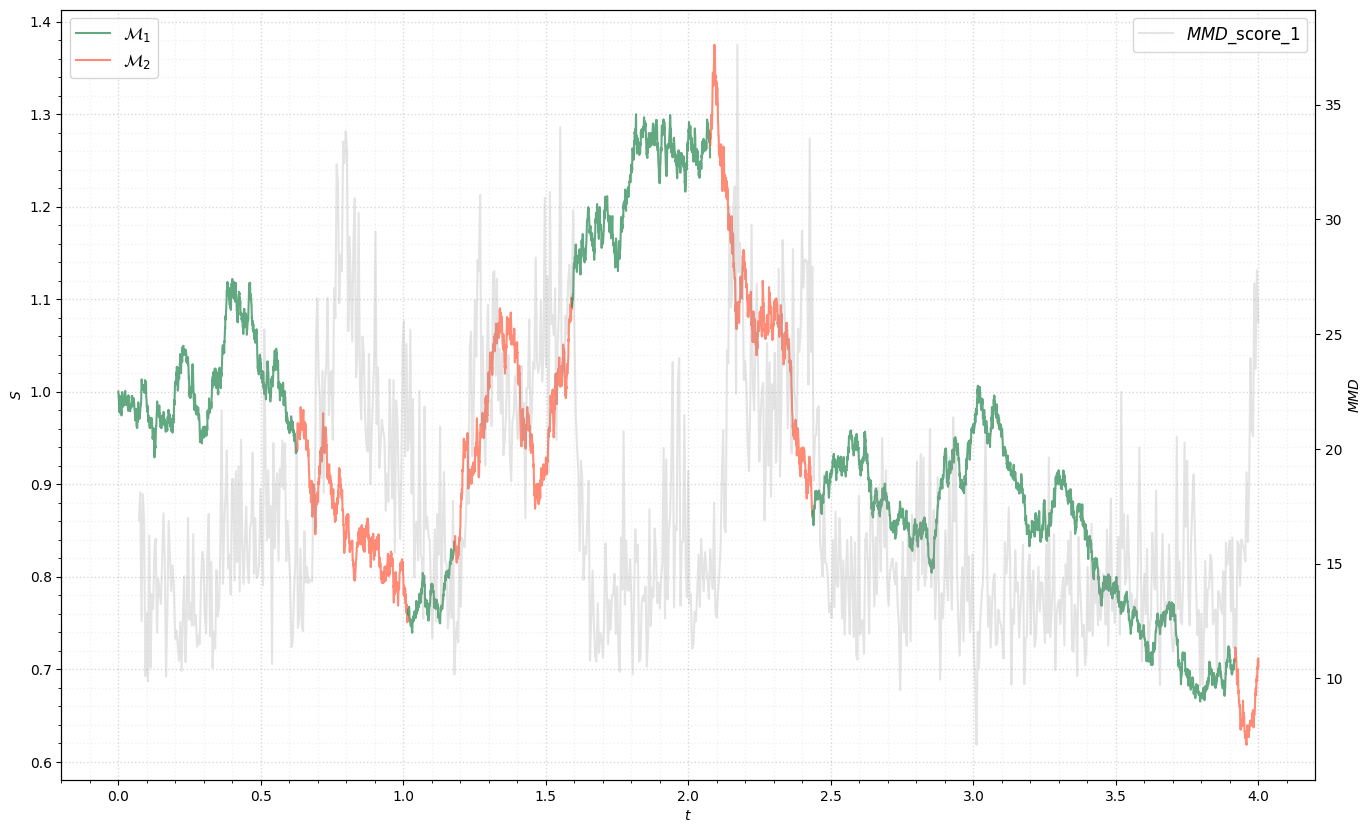

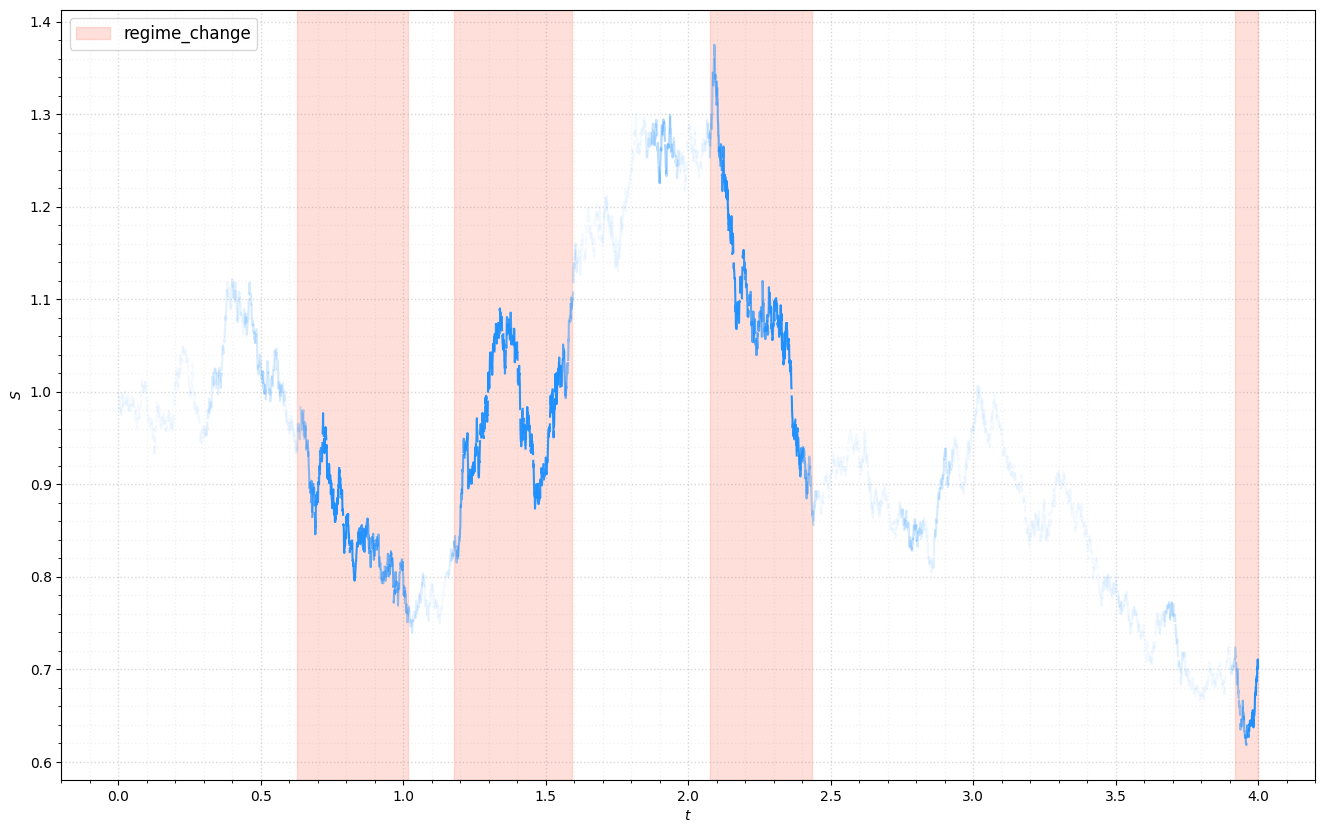

In [40]:
# Plot MMD scores
index = general_scores_array[0, :]

for score in general_scores_array[1:, :]:
    this_score_array = np.vstack([index, score])
    plot_path_experiment_result(test_path, this_score_array, path_splits_mesh, diff=False)

# Plot test threshold performance
for alphas in mmd_alphas:
    plot_path_test_threshold(sub_paths, alphas, path_splits_time, one_dim=True)

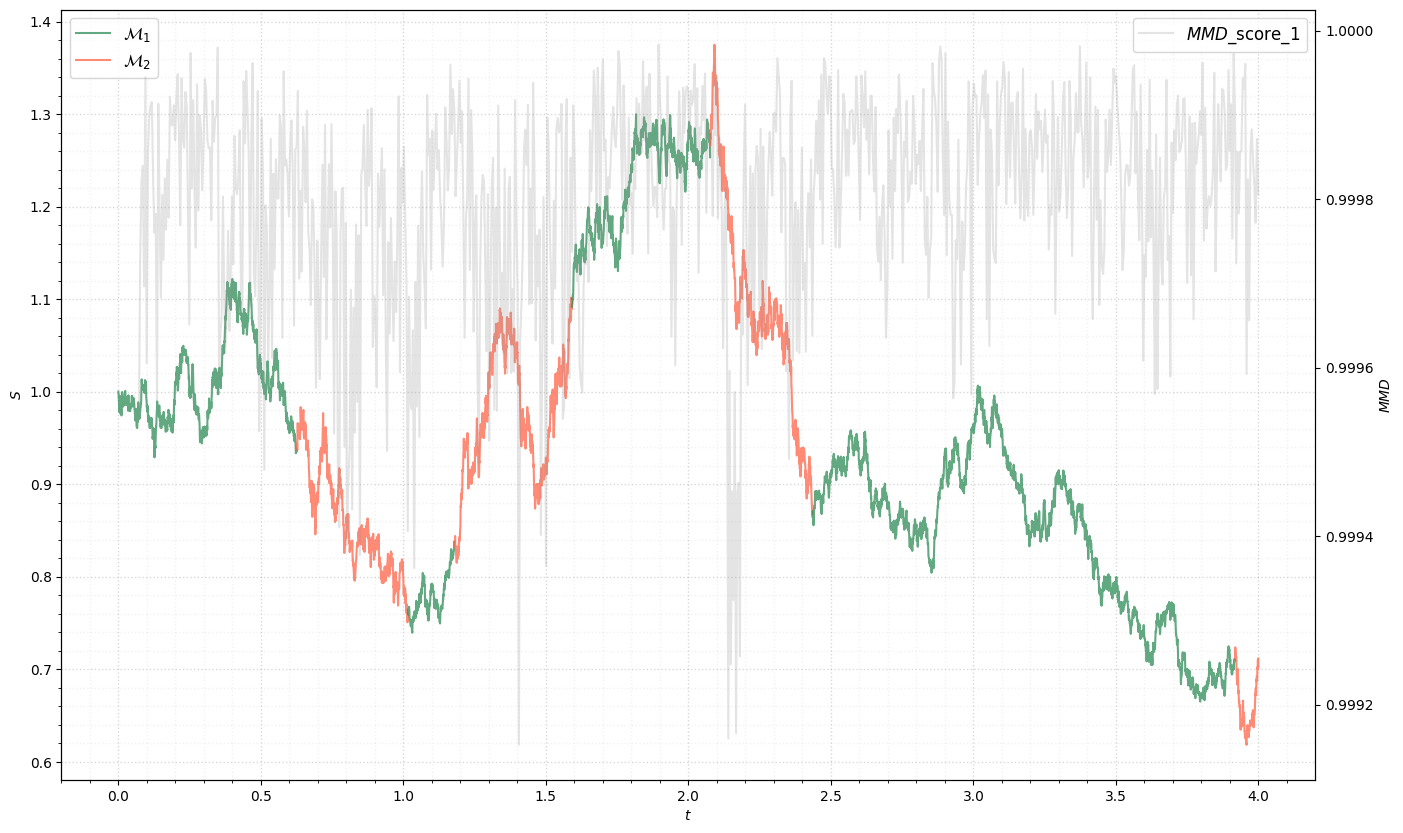

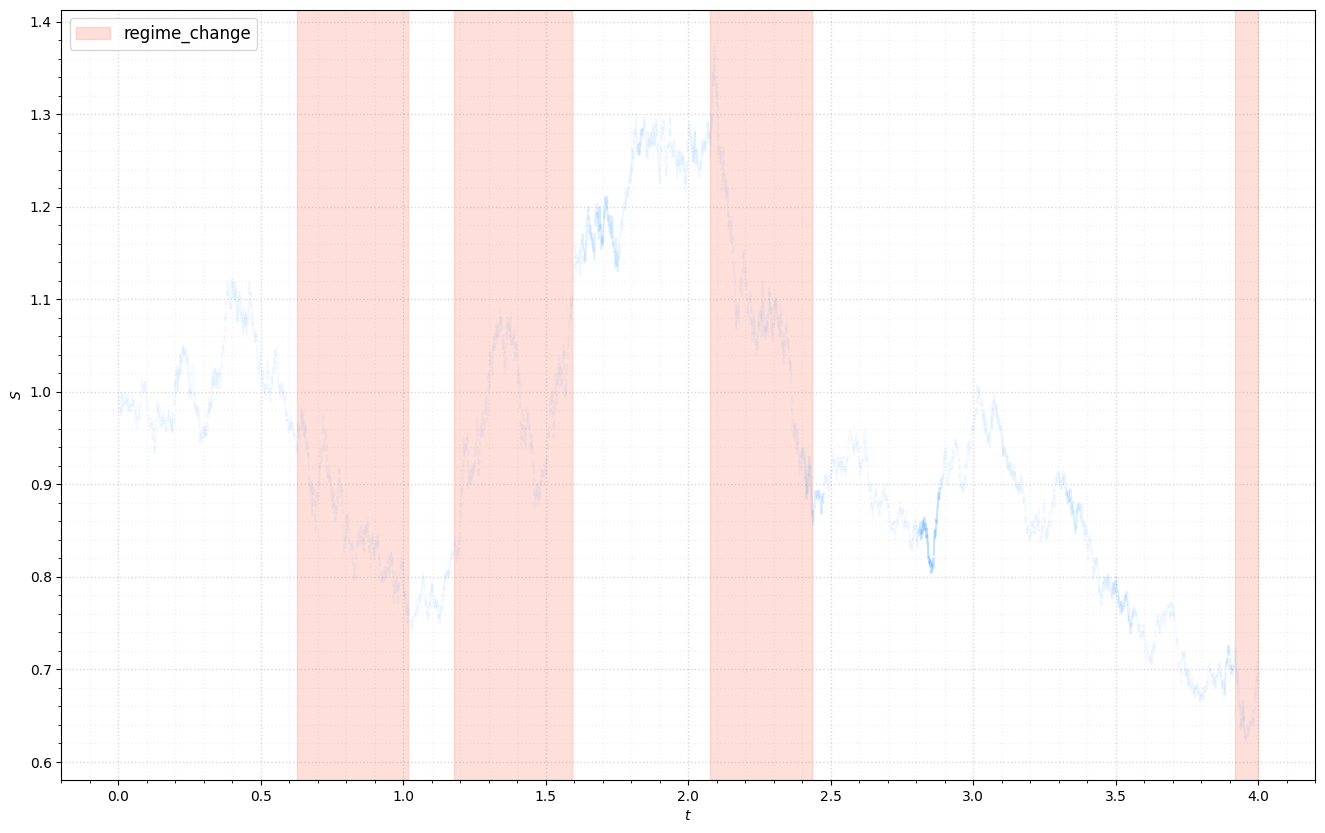

In [41]:
# Plot MMD scores
index = truncated_scores_array[0, :]

for score in truncated_scores_array[1:, :]:
    this_score_array = np.vstack([index, score])
    plot_path_experiment_result(test_path, this_score_array, path_splits_mesh, diff=False)

# Plot test threshold performance
for alphas in mmd_t_alphas:
    plot_path_test_threshold(sub_paths, alphas, path_splits_time, one_dim=True)

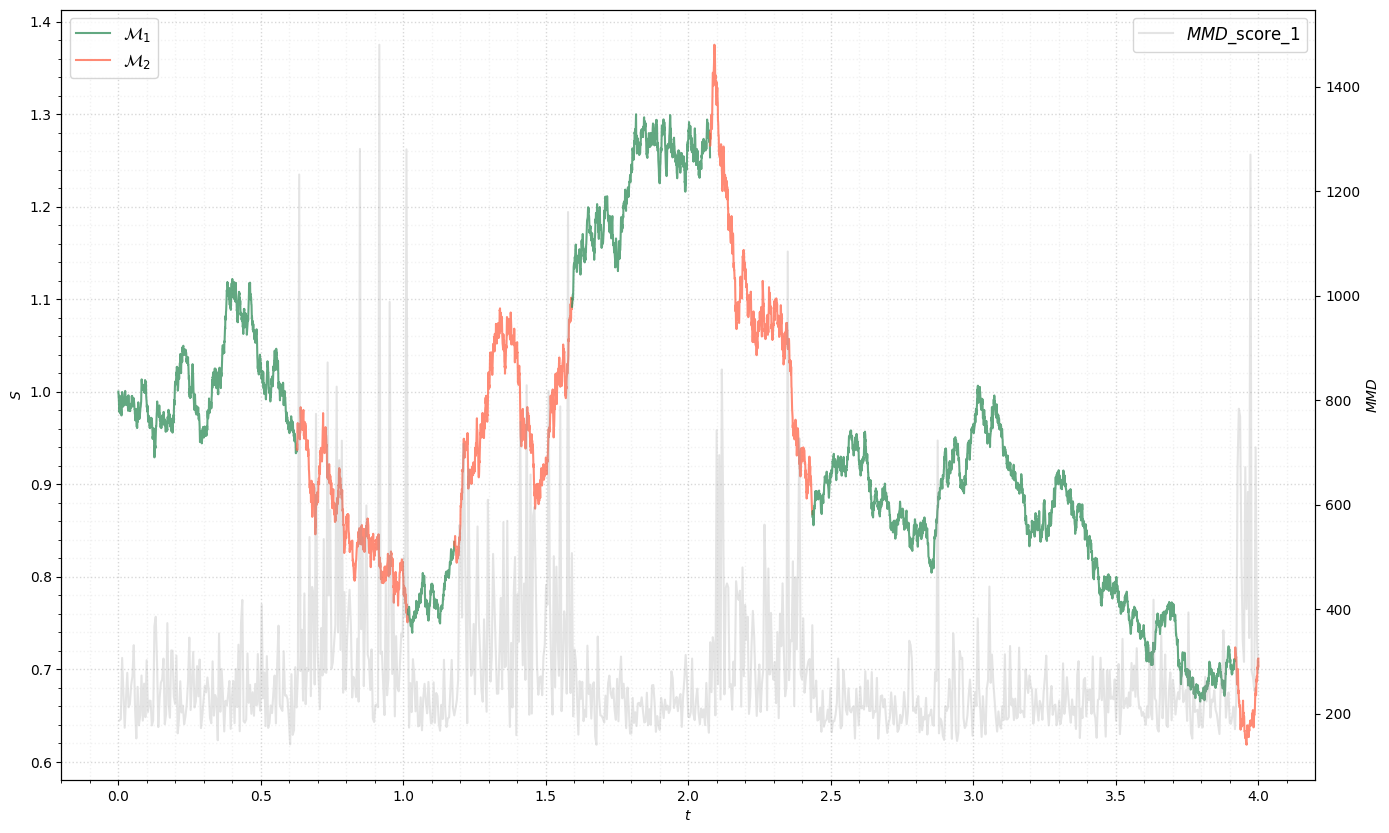

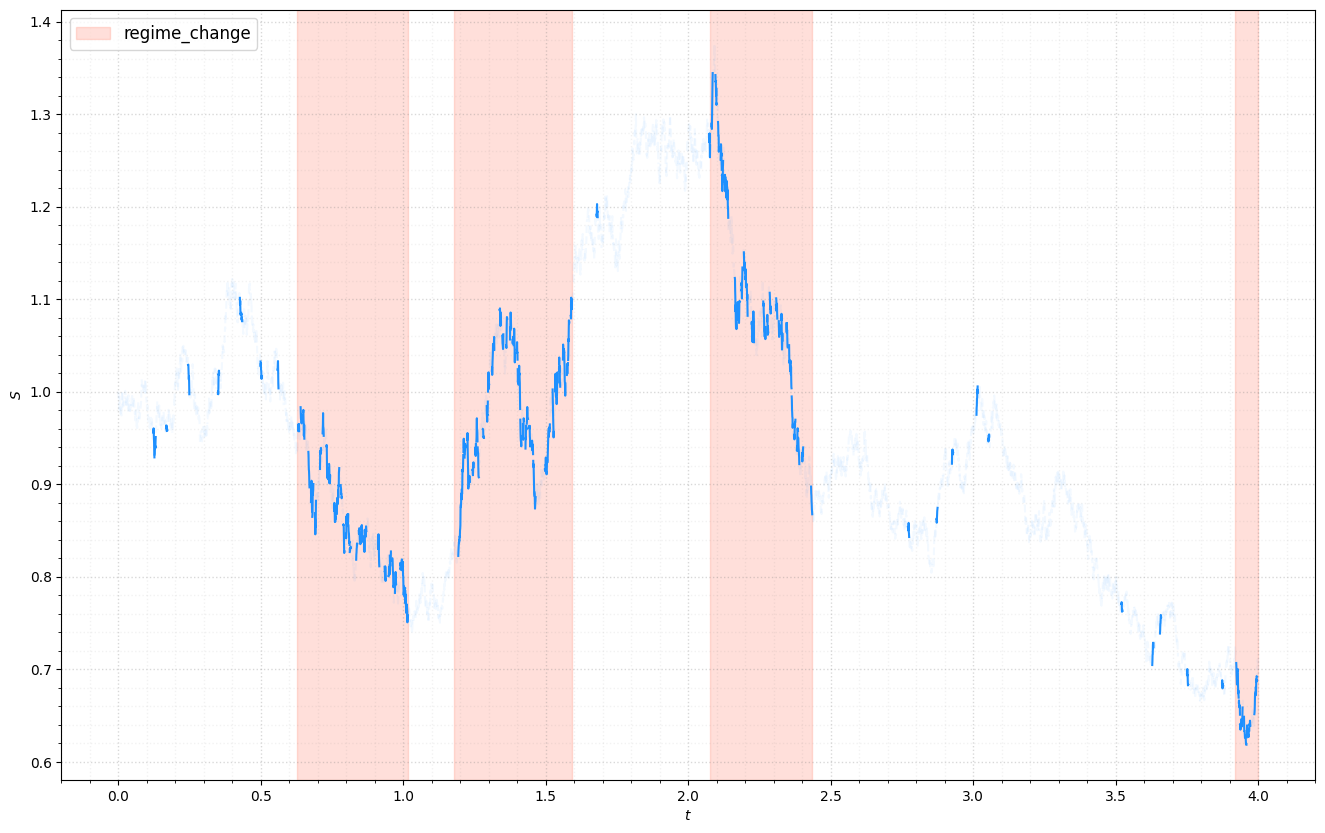

In [42]:
plot_path_experiment_result(test_path, anomaly_scores_array, path_splits_mesh, diff=False)
plot_path_test_threshold(sub_paths, anomaly_alphas, path_splits_time, one_dim=True)

<div style="background: navy; color: white; padding: 20px">

## 7. Report scores

In [43]:
# Scores
general_scores_dict = alpha_score_function(
    regime_changes = regime_partitioner.regime_changes,
    path_length    = len(test_path),
    memberships    = memberships,
    test_alphas    = mmd_alphas[0],
    test_data      = [n_steps, offset, n_paths]
)

print("General_MMD_Detector scores")
for k, v in general_scores_dict.items():
    print("{}: {:.4f}%".format(k, v*100))

General_MMD_Detector scores
regime_on: 80.6624%
regime_off: 93.3902%
total: 89.4362%


In [44]:
# Scores
truncated_scores_dict = alpha_score_function(
    regime_changes = regime_partitioner.regime_changes,
    path_length    = len(test_path),
    memberships    = memberships,
    test_alphas    = mmd_t_alphas[0],
    test_data      = [n_steps, offset, n_paths]
)

print("Truncated_MMD_Detector scores")
for k, v in truncated_scores_dict.items():
    print("{}: {:.4f}%".format(k, v*100))

Truncated_MMD_Detector scores
regime_on: 1.0773%
regime_off: 95.4770%
total: 66.1510%


In [45]:
anomaly_scores_dict = alpha_score_function(
    regime_changes = regime_partitioner.regime_changes,
    path_length    = len(test_path),
    memberships    = memberships,
    test_alphas    = anomaly_alphas,
    test_data      = [n_steps, offset, n_paths]
)

print("Anomaly_Detector scores")
for k, v in anomaly_scores_dict.items():
    print("{}: {:.4f}%".format(k, v*100))

Anomaly_Detector scores
regime_on: 48.4033%
regime_off: 96.5461%
total: 81.5901%
